# Segmentation with graph convolutional networks on 2D toy data

In this notebook we explore a variation on the hit classification task explored in the GCN_Toy2D notebook.

Here, we formulate the graph using _hit segments_ as nodes and connect them with edges representing their connectedness and compatibility. The end goal is no longer hit classification but _segment classification_.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
cuda = False

In [2]:
# System imports
from __future__ import print_function
from timeit import default_timer as timer

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib notebook

In [3]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n).astype(np.float32)
    xout = np.random.uniform(size=n).astype(np.float32)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def generate_data(n_events, n_tracks, det_r):
    n_det_layers = det_r.shape[0]
    
    # Generate all the tracks we'll need
    x = np.stack([gen_tracks(n_events, det_r)
                  for i in range(n_tracks)], axis=-1)

    # Sort the hits by position; use sort index as labels
    y = np.argsort(x, axis=-1)
    x.sort(axis=-1)

    # Detector depth (radius) coordinate
    r = np.broadcast_to(det_r[None, :, None], x.shape)
    # Layer number, convenient for constructing adjacencies
    l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], x.shape)

    # Flatten the arrays
    x, y, r, l = [a.reshape((n_events, -1)) for a in [x, y, r, l]]
    return x, y, r, l

In [4]:
def calc_hit_adjacency(l):
    """Simple binary adjacency which connects all hits on adjacent layers"""
    return (np.abs(l[:, None, :] - l[:, :, None]) == 1).astype(np.float32)

def true_hit_adjacency(a, y):
    """True binary adjacency labels"""
    return (y[:, None, :] == y[:, :, None]) * a

def gaus_kernel(dx, sig):
    return np.exp(-(dx**2) / (2*sig**2))

In [5]:
# PyTorch memory allocations and conversions
np_to_torch_cpu = lambda x: Variable(torch.from_numpy(x))
np_to_torch_gpu = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_zeros_cpu = lambda *size: Variable(torch.FloatTensor(*size).zero_())
torch_zeros_gpu = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())

np_to_torch = np_to_torch_gpu if cuda else np_to_torch_cpu
torch_zeros = torch_zeros_gpu if cuda else torch_zeros_cpu

## Generate the data

The data is the same as the hit classification task.

This time, however, we prepare the dual graph where segments are the nodes.
The adjacency matrix has 0's for unconnected segments and a similarity score based on a Gaussian kernel for the slope difference between connected segments.

In [6]:
# Data config
#det_r = np.array([0, 1, 2, 3, 4], dtype=np.float32)
det_r = np.array([0, 1, 2, 3, 5, 7, 9, 11, 13, 15], dtype=np.float32)
n_det_layers = det_r.shape[0]
n_events = 2**15
n_tracks = 5

In [7]:
# Generate the track hits
hit_x, hit_y, hit_r, hit_l = generate_data(n_events, n_tracks, det_r)
print(hit_x.shape, hit_y.shape, hit_r.shape, hit_l.shape)

(32768, 50) (32768, 50) (32768, 50) (32768, 50)


In [8]:
# Hit adjacency
hit_adj = calc_hit_adjacency(hit_l)
hit_adj.shape

(32768, 50, 50)

In [9]:
def get_segment_indices(hit_adj, n_events, n_segments):
    return (np.stack(np.triu(hit_adj).nonzero()[1:], axis=-1)
            .reshape(n_events, n_segments, -1))

In [11]:
# Identify all considered segments
n_segs = n_tracks * n_tracks * (n_det_layers - 1)
seg_idx = get_segment_indices(hit_adj, n_events, n_segs)
seg_idx.shape

(32768, 225, 2)

In [15]:
# Construct the segment adjacency
seg_adj = np.zeros((n_events, n_segs, n_segs))

# Loop over events and segment pairs
for ievt in range(n_events):
    for iseg in range(n_segs):
        for jseg in range(iseg, n_segs):
            # Segments match if they share the middle hit
            if seg_idx[ievt, iseg, 1] == seg_idx[ievt, jseg, 0]:
                seg_adj[ievt, iseg, jseg] = 1
                seg_adj[ievt, jseg, iseg] = 1

In [18]:
# Compute segment labels
evt_idx = np.arange(n_events)
seg_hit_y = hit_y[evt_idx[:, None, None], seg_idx]
seg_y = (seg_hit_y[:, :, 0] == seg_hit_y[:, :, 1]).astype(np.float32)
seg_y.shape

(32768, 225)

In [19]:
# Compute the slopes of each segment
seg_x = hit_x[evt_idx[:, None, None], seg_idx]
seg_r = hit_r[evt_idx[:, None, None], seg_idx]
seg_dx = np.diff(seg_x).squeeze(-1)
seg_dr = np.diff(seg_r).squeeze(-1)
seg_slope = seg_dx / seg_dr
seg_slope.shape, seg_slope.dtype

((32768, 225), dtype('float32'))

In [20]:
# Compute slope differences between segments
seg_dslope = seg_slope[:, None, :] - seg_slope[:, :, None]

<IPython.core.display.Javascript object>


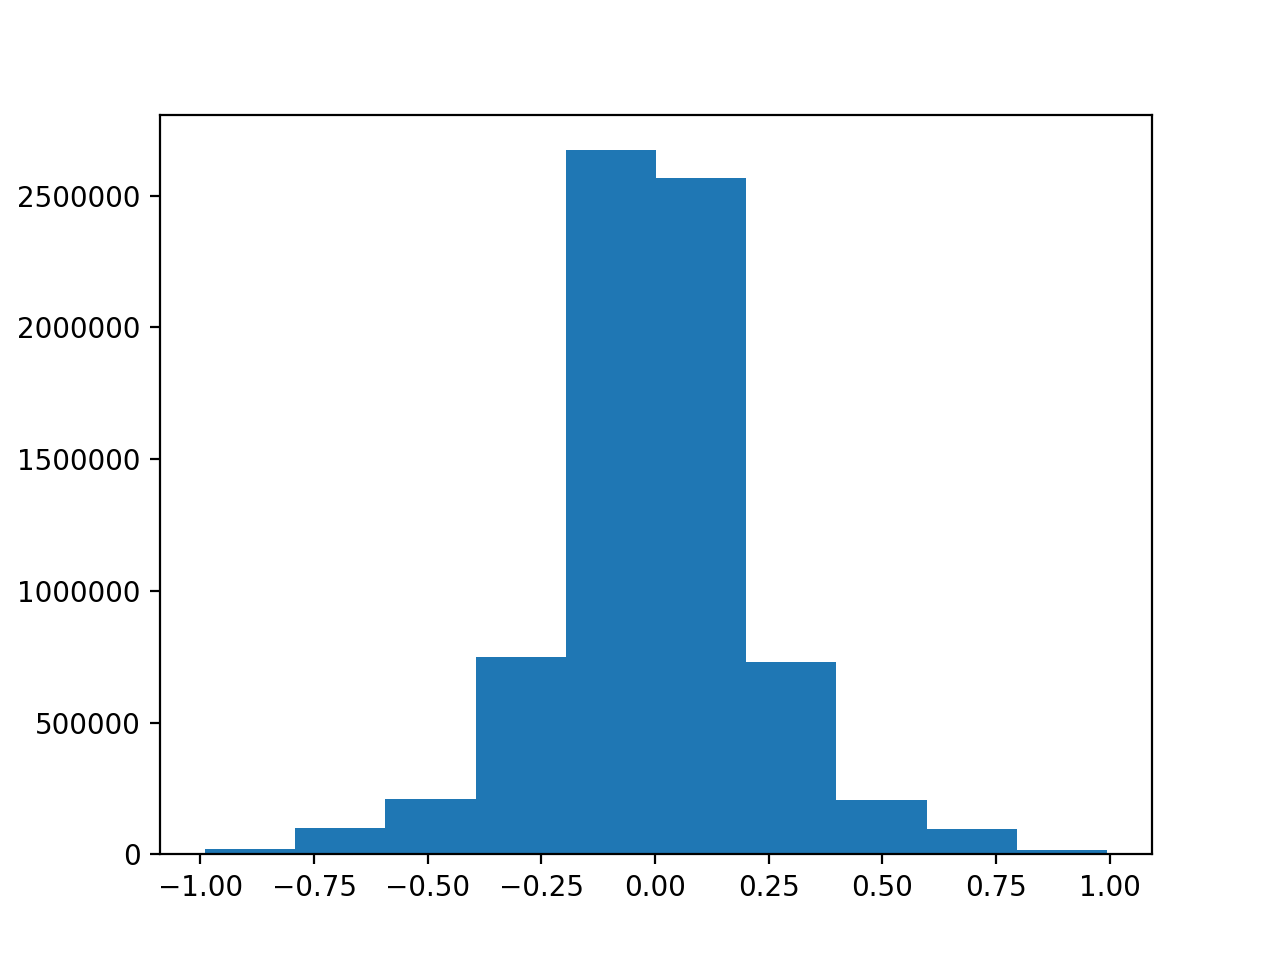

In [21]:
# Check the slope distributions
plt.figure()
plt.hist(seg_slope.flatten());

In [22]:
sigma = 0.01
seg_adj_kernel = gaus_kernel(seg_dslope, sigma)

<IPython.core.display.Javascript object>


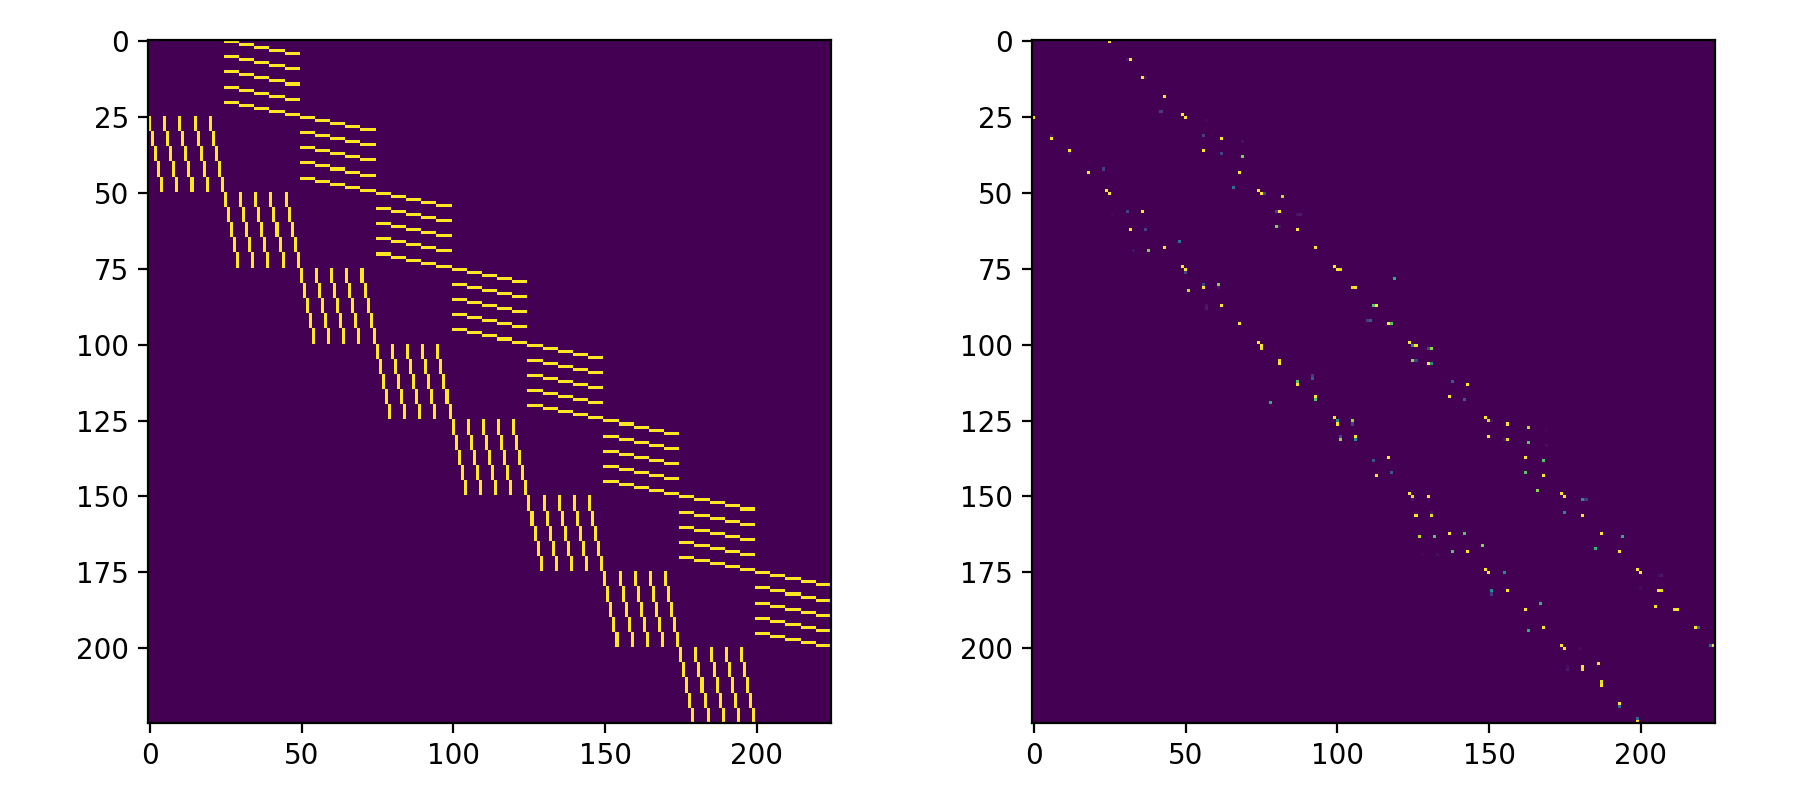

In [37]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(seg_adj[0])
plt.subplot(122)
plt.imshow(seg_adj_kernel[0] * seg_adj[0])
plt.tight_layout()

## Define the model

In [24]:
def repeat_module(module, x):
    """Applies module on last axis, repeating over others"""
    return module(x.view(-1, x.size(-1))).view(x.size()[:-1] + (-1,))

class GraphConv(nn.Module):
    """
    A minimal graph convolution module.
    
    This module takes an input tensor of node features X and some form
    of adjacency matrix A and applies a linear transformation of the form
        A * X * W + b
    where W and b are weights and biases, respectively.
    """
    
    def __init__(self, input_dim, output_dim):
        super(GraphConv, self).__init__()
        # We implement the patch operator as a linear module
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x, a):
        ax = torch.matmul(a, x)
        return repeat_module(self.linear, ax)

class GraphConvSelfInt(nn.Module):
    """
    A graph convolution module with separate explicit self-interaction terms.
    
    This module takes an input tensor of node features X and adjancency
    matrix A and applies a linear transformation of the form
        X*W1 + A*X*W2 + b
    where (W1, W2) and b are learned weights and biases.
    """
    def __init__(self, input_dim, output_dim):
        super(GraphConvSelfInt, self).__init__()
        self.node_mod = nn.Linear(input_dim, output_dim)
        self.neighbor_mod = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x, a):
        node_term = repeat_module(self.node_mod, x)
        neighbor_term = repeat_module(self.neighbor_mod, torch.matmul(a, x))
        return node_term + neighbor_term

In [25]:
class GCNBinaryClassifier(nn.Module):
    """
    A simple graph-convolutional network for binary classification of nodes.
    
    This model applies a feature extractor to each node,
    followed by a number of graph conv layers,
    followed by a node classifier head.
    """
    
    def __init__(self, input_dim, hidden_dims, gc_type=GraphConvSelfInt):
        super(GCNBinaryClassifier, self).__init__()
        # Feature extractor layer
        self.feature_extractor = nn.Linear(input_dim, hidden_dims[0])
        # Graph convolution layers
        n_gc_layers = len(hidden_dims) - 1
        self.gc_layers = nn.ModuleList([gc_type(hidden_dims[i], hidden_dims[i+1])
                                        for i in range(n_gc_layers)])        
        # Node classifier
        self.classifier = nn.Linear(hidden_dims[-1], 1)
    
    def forward(self, x, a):
        # Apply feature extraction layer
        x = F.relu(repeat_module(self.feature_extractor, x))
        # Apply graph conv layers
        for gc in self.gc_layers:
            x = F.relu(gc(x, a))
        # Apply node classifier
        return repeat_module(self.classifier, x).squeeze(-1)

In [26]:
def predict_prob(model, inputs):
    return F.sigmoid(model(inputs))

def training_step(model, inputs, targets, loss_func, optimizer):
    model.train()
    model.zero_grad()
    outputs = model(*inputs)
    loss = loss_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss

def accuracy(probs, target, threshold=0.5):
    return ((probs.data.numpy() > threshold) == (target.data.numpy() > 0.5)).mean()

## Training

In [27]:
# Finalize the dataset.
# Stack features, split into training+test, translate to PyTorch, etc.
seg_X = np.concatenate([seg_x, seg_r, seg_slope[:,:,None]], axis=-1)

# Try an unnormalized kernel adjacency first
seg_A = seg_adj * seg_adj_kernel

In [28]:
# Model config
n_features = seg_X.shape[-1]
hidden_dims = [16, 16, 16, 16, 16]

# Training config
batch_size = 32
n_epochs = 20
test_frac = 0.1

In [29]:
n_train = int(n_events * (1 - test_frac))
n_batches = (n_train + batch_size - 1) // batch_size

# Split data into train and test sets
train_X = np_to_torch(seg_X[:n_train].astype(np.float32))
train_A = np_to_torch(seg_A[:n_train].astype(np.float32))
train_y = np_to_torch(seg_y[:n_train].astype(np.float32))
test_X = np_to_torch(seg_X[n_train:].astype(np.float32))
test_A = np_to_torch(seg_A[n_train:].astype(np.float32))
test_y = np_to_torch(seg_y[n_train:].astype(np.float32))

print('Training samples:', n_train)
print('Batches per epoch:', n_batches)
print('Test samples:', n_events - n_train)

Training samples: 29491
Batches per epoch: 922
Test samples: 3277


In [ ]:
# Construct the model
model = GCNBinaryClassifier(n_features, hidden_dims)
if cuda: model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()
print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

GCNBinaryClassifier (
  (feature_extractor): Linear (5 -> 16)
  (gc_layers): ModuleList (
    (0): GraphConvSelfInt (
      (node_mod): Linear (16 -> 16)
      (neighbor_mod): Linear (16 -> 16)
    )
    (1): GraphConvSelfInt (
      (node_mod): Linear (16 -> 16)
      (neighbor_mod): Linear (16 -> 16)
    )
    (2): GraphConvSelfInt (
      (node_mod): Linear (16 -> 16)
      (neighbor_mod): Linear (16 -> 16)
    )
    (3): GraphConvSelfInt (
      (node_mod): Linear (16 -> 16)
      (neighbor_mod): Linear (16 -> 16)
    )
  )
  (classifier): Linear (16 -> 1)
)
Parameters: 2225


In [ ]:
batch_idxs = np.arange(0, n_train, batch_size)
train_losses, test_losses = [], []

for i in range(n_epochs):
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    for j in batch_idxs:
        batch_X = train_X[j:j+batch_size]
        batch_A = train_A[j:j+batch_size]
        batch_inputs = [batch_X, batch_A]
        batch_y = train_y[j:j+batch_size]
        sum_loss += training_step(model, batch_inputs, batch_y, loss_func, optimizer)

    end_time = timer()
    avg_loss = sum_loss.cpu().data[0] / n_batches
    train_losses.append(avg_loss)
    print('  training loss %.3g' % avg_loss, 'time %gs' % (end_time - start_time))
    
    # Evaluate the model on the test set
    model.eval()
    test_output = model(test_X, test_A)
    test_loss = loss_func(test_output, test_y).cpu().data[0]
    test_losses.append(test_loss)
    print('  test loss %.3g' % test_loss)

Epoch 0
  training loss 0.138 time 23.2743s
  test loss 0.0785
Epoch 1
  training loss 0.0622 time 21.6179s
  test loss 0.0514
Epoch 2
  training loss 0.0464 time 21.7954s
  test loss 0.0422
Epoch 3
  training loss 0.0402 time 21.7197s
  test loss 0.0375
Epoch 4


## Evaluation

In [ ]:
# Evaluate accuracy on the test set
test_probs = F.sigmoid(test_output)

In [35]:
accuracy(test_probs, test_y, threshold=0.5)

0.98603193978232118

<IPython.core.display.Javascript object>


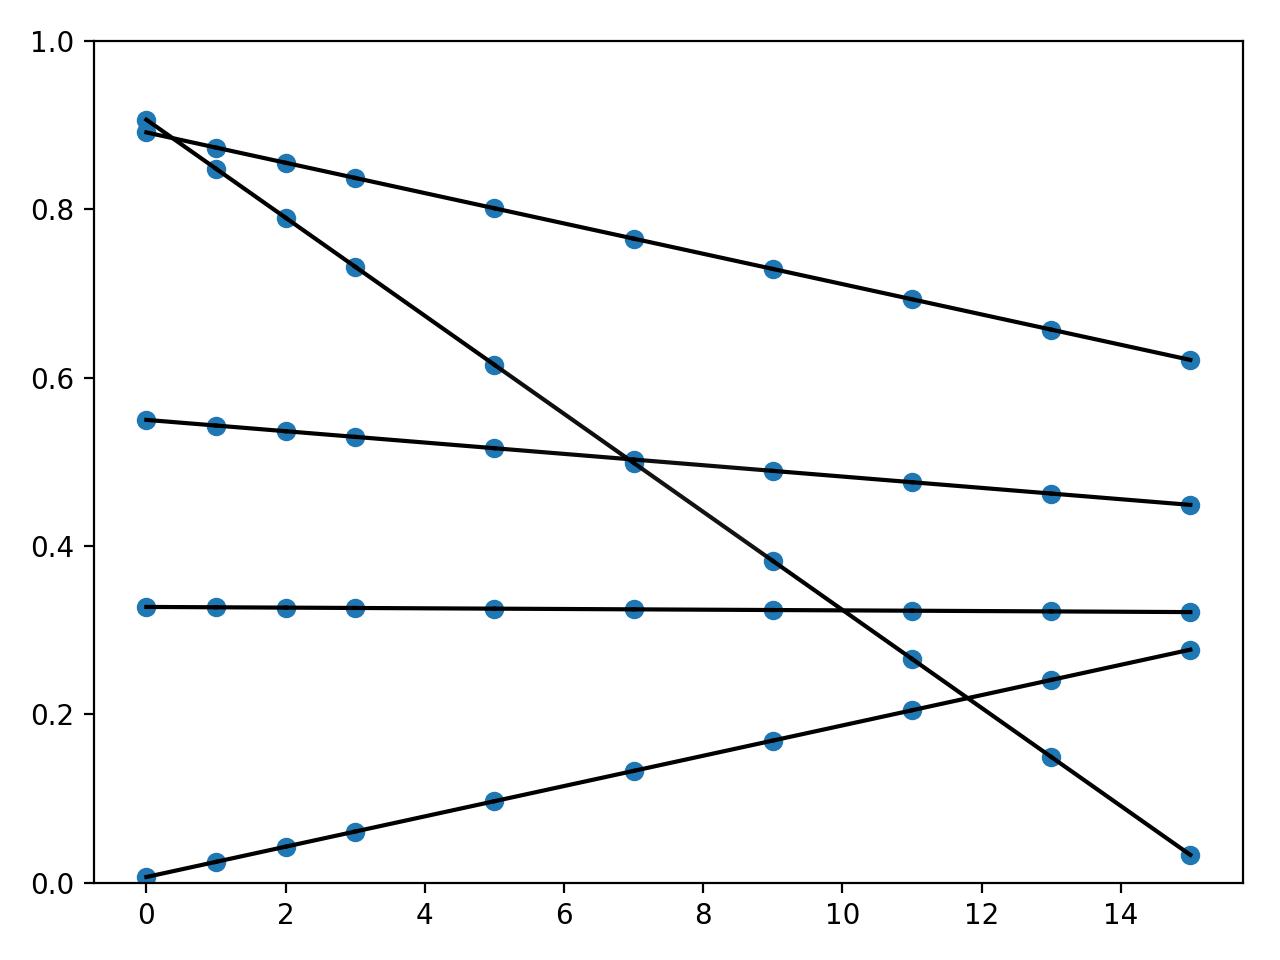

In [36]:
# Choose a sample to visualize out of the test set
i = 1
sample_hit_r, sample_hit_x = hit_r[n_train+i], hit_x[n_train+i]
sample_seg_r, sample_seg_x = seg_r[n_train+i], seg_x[n_train+i]
sample_seg_prob = test_probs[i].cpu().data.numpy()

# Create a figure for showing the segment predictions
plt.figure()

# Draw all the hits
plt.scatter(sample_hit_r, sample_hit_x)

# Draw the segments with darkness set by prediction probability
for iseg in range(n_segs):
    plt.plot(sample_seg_r[iseg], sample_seg_x[iseg], 'k-', alpha=sample_seg_prob[iseg])

plt.ylim((0, 1))
plt.tight_layout()

## Discussion

This was an interesting preliminary study on graph conv models for the track segment graph (with segments as nodes and hits as edges). Performance seemed highly dependent on the distinguishing power of the similarity kernel. With a sharp enough gaussian distribution to weight the similarity of connected segments, the model could seemingly learn to classify segments easily. However, the classification task becomes trivial when the similarity only selects correct adjacent segments (any segment that has neighbors then is real). When the gaussian kernel width is relaxed somewhat, performance falls dramatically.

So it seems like something is still missing here and performance of the model is not yet satisfactory.